<table width=100%><tr>
 <td width=170px> <img src="../images/logo.png" alt="Oxford Logo" height="160" width="160"></td>
 <td style="font-size: 35px; text-align:left"> 
 <table>
  <tr><td style="font-size: 30px; text-align:left"> Mining Digital Identity Insights: <br>Patent Analysis using NLP</td></tr>

  </table>   
 </td>
 <td width=200>
 <table>
 <tr><td>  Matthew Comb (2910648)</td></tr>
  <tr><td>matthew.comb@linacre.ox.ac.uk</td></tr>
 <tr><td>  Dr Andrew Martin</td></tr>
  <tr><td>andrew.martin@kellogg.ox.ac.uk</td></tr>
  </table>
  </td></tr>
</table>

<table width=100%>
<tr>
<td style="font-size: 15px; text-align:left"> | 1. Patent Analysis Summary</td>
</tr>
</table>

  

# Abstract <a class="anchor" id="research-abstract"></a>

The field of digital identity innovation has grown significantly over the last 30 years, with over 6,000 technology patents registered worldwide. However, many questions remain about who controls and owns our digital identity and intellectual property and, ultimately, where the future of digital identity is heading.

To investigate this further, this research mines digital identity patents and explores core themes such as identity, systems, privacy, security, and emerging fields like blockchain, financial transactions, and biometric technologies. Utilizing natural language processing (NLP) methods, including part-of-speech tagging, clustering, topic classification, noise reduction, and lemmatisation techniques. Finally, the research employs graph modelling and statistical analysis to discern inherent trends and forecast future developments.

The findings significantly contribute to the digital identity landscape, identifying key players, emerging trends, and technological progress. This research serves as a valuable resource for academia and industry stakeholders, aiding in strategic decision-making and investment in emerging technologies and facilitating navigation through the dynamic realm of digital identity technologies.

# Table of Contents:

* [Abstract](#research-abstract)
* [Introduction](#introduction)
* [Research Questions](#research-questions)
* [Data Collection](#data-collection)
* [Initialisation](#initialisation)
* [Helper Functions](#helper-functions)
* [Data Loading](#data-loading)
* [Data Cleaning](#data-cleaning)
* [Patent Leaders](#patent-leaders)
* [Patents Over Time](#patents-over-time)
* [Period Leaders [1996-2020]](#period-leaders)
* [Company Patent Metrics](#company-patent-metrics)
* [Company Patents By Year](#company-patents-by-year)
* [Company Patent Links](#company-patent-links)
* [Patent Downloading](#patent-downloading)


# Introduction <a class="anchor" id="introduction"></a>

 This Jupyter notebook is designed to provide an analysis of the filing entities, filing years, and associated metadata of digital identity patents, focusing strictly on the descriptive aspects without examining the patents' content. The aim is to offer insights into the patterns of patent filings, including who is filing patents, when these patents are being filed, and any notable trends in the metadata that might indicate shifts or developments in the field of digital identity.

# Research Questions <a class="anchor" id="research-questions"></a>

1. Who owns the patents behind present day digital identity technology ?
2. Who is most active in the domain ?
3. Are there any noticeable trends present in the patent dataset ?


# Data Collection <a class="anchor" id="data-collection"></a>

1. Source: This repository contains a version of the patent database which can be refreshed by downloading from: <br> https://patents.google.com/?q=("digital+identity")&oq="digital+identity"
2. Criteria: the combined term "digital identity" is used as the primary search term. This term must be encases in quotations to ensure "digital" patents are not included. Expected data set is somewhere around 6000+ patents after downloaded n.b. search returns more matches due to variants in files submitted to the registrar. Check the row count in the csv file.
3. Data Format: The file is downloaded in CSV format which is compatible with the remainder of this notebook
4. N.b. Please remove the top row from the file if it contains the search string, but use notepad or a raw text editor to do this. Loading into excel and saving may alter the date format of the file.

## Initialisation <a class="anchor" id="initialisation"></a>

In [1]:
# import python data analysis library
import pandas as pd

# pd.set_option('max_columns', 120)
# pd.set_option('max_rows', 20)

In [2]:
# import scientific platform package
import numpy as np

In [3]:
# HTML imports
from IPython.core.display import display, HTML

In [4]:
# Beautiful Soup
from bs4 import BeautifulSoup

In [5]:
# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# import scientific modelling library
from sklearn import linear_model

# set initial configuration values
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams["figure.figsize"] = (13, 3)

# enable plots to be embedded within the notebook
%matplotlib inline

In [96]:
from difflib import SequenceMatcher

## Helper Functions <a class="anchor" id="helper-functions"></a>

In [6]:
# Helper function to analyse NaN values
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [7]:
# Helper function to select data per time period
def select_period(df, start_year, end_year, id):
    new = df[(df.Year.astype(int) >= start_year) & (df.Year.astype(int) <= end_year)].copy()
    new['ruleset'] = id
    return new

In [8]:
# Helper function to rank by Year
def rank_by_year_and(df):
    x = df[['Assignee','Year']].sort_values( by=[], ascending=False)
    x['Rank']= df[y].count().rank(ascending=False)
    return x

In [9]:
# Helper function to move data between dataframes
def fill_stat2(df, st, a, i):
    if (a.size > i):
        pd.DataFrame(df).iloc[i][(st,'Assignee')] = a.iloc[i]['Assignee']
        pd.DataFrame(df).iloc[i][(st,'Count')] = a.iloc[i]['Name']
    return df

In [10]:
# Helper function to display company specific metrics according to known periods
def display_entity(df, entity_name, words = [], ranges = [], range_start = 0, range_end = 0): 

    df = df.sort_values(by='CreationDate')  
    
    # Print the number in dataset just for quality control
    print("Dataset Patent Count: " + str(df.shape[0]))
    print("")
    
    # Prepare the datasets for the periods 
    df_entity = df[df['Assignee'].str.contains(entity_name)]
    df_after = df_entity[df_entity['CreationDate'].dt.year >= 2021]
    df_period = df_entity[df_entity['CreationDate'].dt.year >= 1996]
    df_period = df_period[df_period['CreationDate'].dt.year <= 2020]
    
    # Output core statistics
    print("Company: " + entity_name)
    print("  Patents (Total): " + str(df_entity.shape[0]))
    print("  Patents (Period [1996-2020]): " + str(df_period.shape[0]))
    print("  Patents (After [2021-2023]): " + str(df_after.shape[0]))

    # Output stats for keywords

    for word in words:
        df_word = df_entity[df_entity['Title'].str.lower().str.contains(word)]
        print("  Patents with word (" + word + "): " + str(df_word.shape[0]))
        
    for r in ranges:
        df_range = df_entity
        df_range = df_range[df_range['CreationDate'].dt.year >= r[1]]
        df_range = df_range[df_range['CreationDate'].dt.year <= r[2]]
        print("  Patents in range (" + r[0] + "): " + str(df_range.shape[0]))
        if (len(r[3]) != 0):
            for word in r[3]:
                df_word = df_range[df_range['Title'].str.lower().str.contains(word)]
                print("  Patents in range (" + r[0] + ") with word (" + word + "): " + str(df_word.shape[0]))
                #df_range = df_range[df_range['Title'].str.lower().str.contains(r[3])]
    
    print("")
    summary = pd.concat([df_entity.head(1), df_entity.tail(1)])
    for indices, row in summary.iterrows():
        print(str(row['CreationDate']) + ": " + row['Title'][:75] + ".. (" + row['ID'] + ")" )

In [11]:
def output_leaders(df):
    allTimeContributers = pd.DataFrame(df['Assignee'].value_counts().reset_index())
    allTimeContributers = allTimeContributers.rename(columns = {'Assignee': 'Count', 'index': 'Assignee'}, inplace = False)
    print(allTimeContributers.head(12))

In [12]:
def print_patents_for_period(df, name):
    print("Patents for " + name)
    for indices, row in df.iterrows():
        id = row['ID'].replace('-','')
        display(HTML("  " + str(row['CreationDate']) + ": " + row['Title'][:60] + ".. " + """<a href="https://patents.google.com/patent/""" + id + """/en" target="_blank">""" + row['ID'] + """</a>"""))

In [13]:
# Helper function to analyse NaN values
def print_all_patents(df, entity_name, words = [], ranges = [], range_start = 0, range_end = 0): 
    df = df.sort_values(by='CreationDate')  
    
    # Print the number in dataset just for quality control
    print("Dataset Patent Count: " + str(df.shape[0]))
    print("")
    print("Company: " + entity_name)
    
    # Prepare the datasets for the periods 
    df_entity = df[df['Assignee'].str.contains(entity_name)]
    df_after = df_entity[df_entity['CreationDate'].dt.year >= 2021]
    df_period = df_entity[df_entity['CreationDate'].dt.year >= 1996]
    df_period = df_period[df_period['CreationDate'].dt.year <= 2020]
    
    print_patents_for_period(df_period, "Period [1996-2020]")
    print_patents_for_period(df_after, "After [2021-2023]")

In [77]:
def strip_last_period_modified(s):
    
    if s is None:
        return ''
    
    # Check if the string is at least 3 characters long, ends with a period, and the third-to-last character is not a period
    if len(s) >= 3 and s.endswith('.') and s[-3] != '.':
        # Remove the last character
        return s[:-1]
    # If the string is shorter than 3 characters but ends with a period, also remove the last character
    elif len(s) < 3 and s.endswith('.'):
        return s[:-1]
    # Return the original string if conditions are not met
    return s

In [89]:
def correct_case(s):

    words = s.split()
    corrected_words = []

    for word in words:
        # Check if the word is likely an acronym (contains periods or is a short word in uppercase)
        if '.' in word or (word.isupper() and len(word) <= 4):
            # Ensure each letter is capitalized, especially for acronyms with periods
            corrected_word = ''.join([letter.upper() for letter in word if letter.isalpha()])
            # Add back the periods if they were present
            corrected_words.append('.'.join([corrected_word[i:i+1] for i in range(0, len(corrected_word))]))
        else:
            # Capitalize the first letter of the word
            corrected_words.append(word.capitalize())

    # Join the corrected words back into a string
    return ' '.join(corrected_words)


In [138]:
def remove_chars(s):
    output_string = s.replace(",", "")
    output_string = output_string.replace(".", "")
    output_string = output_string.replace("INC", "Inc")
    output_string = output_string.replace("Llc", "LLC")
    return output_string

In [95]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [210]:
# Helper function to find partial matched entities
def find_partial_matches(companies):
    for company1 in companies:
        for company2 in companies:
            #print(company1)
            if company1 != company2:
                if similar(company1, company2) > 0.9:
                    print(f'wd.loc[wd["Assignee"].str.contains({company1!r}), "Assignee"] = {company2!r}')

## Data Loading<a class="anchor" id="data-loading"></a>

In [280]:
# Load Patent dataset
wd = pd.read_csv("../Data/Google/digital-identity-full.csv")
print ("Dataset Patent Count: " + str(wd.shape[0]))

Dataset Patent Count: 6167


In [281]:
# Rename Columns to be consistent
wd = wd.rename(columns={'id': 'ID'})
wd = wd.rename(columns={'title': 'Title'})
wd = wd.rename(columns={'assignee': 'Assignee'})
wd = wd.rename(columns={'inventor/author': 'Inventor'})
wd = wd.rename(columns={'priority date': 'PriorityDate'})
wd = wd.rename(columns={'filing/creation date': 'CreationDate'})
wd = wd.rename(columns={'publication date': 'PublicationDate'})
wd = wd.rename(columns={'grant date': 'GrantDate'})
wd = wd.rename(columns={'result link': 'Result'})
wd = wd.rename(columns={'representative figure link': 'Figure'})

In [282]:
wd.dropna(subset = ['CreationDate'], inplace=True)
wd.dropna(subset = ['Assignee'], inplace=True)
print ("Adjusted Patent Count: " + str(wd.shape[0]))

Adjusted Patent Count: 6157


## Data Cleaning<a class="anchor" id="data-cleaning"></a>

In [283]:
# Clean data into English
wd["Assignee"].replace({"한국전자통신연구원": "Electronics and Telecommunications Research Institute"}, inplace=True)
wd["Assignee"].replace({"华为技术有限公司": "Huawei"}, inplace=True)
wd["Assignee"].replace({"珠海优特电力科技股份有限公司": "Zhuhai Untech Power Technology Co.,Ltd."}, inplace=True)
wd["Assignee"].replace({"深圳市元征科技股份有限公司": "Launch Tech"}, inplace=True)
wd["Assignee"].replace({"阿里巴巴集团控股有限公司": "Alibaba"}, inplace=True)
wd["Assignee"].replace({"北京飞天诚信科技有限公司": "Beijing Feitian Chengxin Technology Co.,Ltd."}, inplace=True)
wd["Assignee"].replace({"中兴通讯股份有限公司": "ZTE"}, inplace=True)
wd["Assignee"].replace({"湖南大学": "Hunan University"}, inplace=True)
wd["Assignee"].replace({"中国信息通信研究院": "China Academy of Information and Communications Technology"}, inplace=True)
wd["Assignee"].replace({"网易（杭州）网络有限公司": "NetEase (Hangzhou) Network Co., Ltd"}, inplace=True)
wd["Assignee"].replace({"支付宝(杭州)信息技术有限公司, 蚂蚁区块链科技(上海)有限公司": "Alipay (Hangzhou) Information Technology Co., Ltd., Ant Blockchain Technology (Shanghai) Co., Ltd"}, inplace=True)
wd["Assignee"].replace({"新大陆（福建）公共服务有限公司": "Newland (Fujian) Public Service Co., Ltd"}, inplace=True)
wd["Assignee"].replace({"中国电信股份有限公司": "China Telecom Corporation Limited"}, inplace=True)
wd["Assignee"].replace({"重庆邮电大学": "Chongqing University of Posts and Telecommunications"}, inplace=True)
wd["Assignee"].replace({"广东工业大学	": "Guangdong University of Technology"}, inplace=True)
wd["Assignee"].replace({"中国联合网络通信集团有限公司": "China Unicom"}, inplace=True)
wd["Assignee"].replace({"中国美术学院": "China Academy of Art"}, inplace=True)
wd["Assignee"].replace({"Дайболд, Инкорпорейтед": "Diebold, Incorporated"}, inplace=True)
wd["Assignee"].replace({"李玉彬": "Li Yubin"}, inplace=True)
wd["Assignee"].replace({"微软公司": "Microsoft Corporation"}, inplace=True)
wd["Assignee"].replace({"Bundesdruckerei GmbH": "Bundesdruckerei Gmbh"}, inplace=True)
wd["Assignee"].replace({"Diebold Inc": "Diebold, Incorporated"}, inplace=True)
wd["Assignee"].replace({"Verizon Patent And Licensing Inc., Cellco Partnership": "Verizon Patent And Licensing Inc."}, inplace=True)
wd["Assignee"].replace({"Verizon Patent And Licensing, Inc.": "Verizon Patent And Licensing Inc."}, inplace=True)
wd["Assignee"].replace({"Forcepoint Llc": "Forcepoint, LLC"}, inplace=True)
wd["Assignee"].replace({"Alibaba": "Alibaba/Alipay"}, inplace=True)
wd["Assignee"].replace({"支付宝(杭州)信息技术有限公司": "Alibaba/Alipay"}, inplace=True)
wd["Assignee"].replace({"Alibaba Group Holding Limited": "Alibaba/Alipay"}, inplace=True)
wd["Assignee"].replace({"Alipay (Hangzhou) Information Technology Corporation": "Alibaba/Alipay"}, inplace=True)
wd["Assignee"].replace({"镇江精英软件科技有限公司": "Zenjiang Elite"}, inplace=True)
wd["Assignee"].replace({"北京兆信信息技术股份有限公司": "PanPass"}, inplace=True)
wd["Assignee"].replace({"北京神秘谷数字科技有限公司": "Mystic Valley"}, inplace=True)
wd["Assignee"].replace({"王彦成": "Wang Yancheng"}, inplace=True)
wd["Assignee"].replace({"郑州信大捷安信息技术股份有限公司": "Zhengzhou"}, inplace=True)
wd["Assignee"].replace({"腾讯科技（深圳）有限公司": "Tencent Tech"}, inplace=True)
wd["Assignee"].replace({"中链科技有限公司": "Sinochain"}, inplace=True)
wd["Assignee"].replace({"中国工商银行股份有限公司": "Industrial and Commercial Bank of China Limited"}, inplace=True)
wd["Assignee"].replace({"蚂蚁区块链科技(上海)有限公司": "Ant Blockchain Technology (Shanghai) Co., Ltd"}, inplace=True)
wd["Assignee"].replace({"卓望数码技术（深圳）有限公司": "Aspire Digital Technology (Shenzhen) Co., Ltd"}, inplace=True)

In [284]:
#strip last . if not acronym
wd['Assignee'] = wd['Assignee'].apply(strip_last_period_modified)
wd['Assignee'] = wd['Assignee'].apply(correct_case)
wd['Assignee'] = wd['Assignee'].apply(remove_chars)

In [285]:
# Handle partial match scenarios
# Mostly these are due to typing mistakes in the entity name when filing the patent
wd.loc[wd['Assignee'].str.contains('Diebold, Incorporated,'), 'Assignee'] = 'Diebold, Incorporated'
wd.loc[wd['Assignee'].str.contains('Американ Экспресс Тревл Рилейтед Сервисиз'), 'Assignee'] = 'American Express'
wd.loc[wd['Assignee'].str.contains('American Express'), 'Assignee'] = 'American Express'
wd.loc[wd['Assignee'].str.contains('Alipay '), 'Assignee'] = 'Alibaba/Alipay'
wd.loc[wd['Assignee'].str.contains('Diebold '), 'Assignee'] = 'Diebold, Incorporated'
wd.loc[wd['Assignee'].str.contains('Microsoft '), 'Assignee'] = 'Microsoft Corporation'
wd.loc[wd['Assignee'].str.contains('Mastercard International'), 'Assignee'] = 'Mastercard International Incorporated'
wd.loc[wd['Assignee'].str.contains('Avery Dennison Retail'), 'Assignee'] = 'Avery Dennison Retail Information Services LLC'
wd.loc[wd['Assignee'].str.contains('Intel '), 'Assignee'] = 'Intel Corporation'
wd.loc[wd['Assignee'].str.contains('Telefonica Digita'), 'Assignee'] = 'Telefonica Digital Espana SLU'
wd.loc[wd['Assignee'].str.contains('Tata Consultancy '), 'Assignee'] = 'Tata Consultancy Services Limited'
wd.loc[wd['Assignee'].str.contains('Acuant'), 'Assignee'] = 'Acuant Inc.'
wd.loc[wd['Assignee'].str.contains('Applied Neural Technologies'), 'Assignee'] = 'Applied Neural Technologies LTD'
wd.loc[wd['Assignee'].str.contains('Assa Abloy'), 'Assignee'] = 'Assa Abloy AB'
wd.loc[wd['Assignee'].str.contains('At&T'), 'Assignee'] = 'At&T Intellectual Property LP'
wd.loc[wd['Assignee'].str.contains('At&t'), 'Assignee'] = 'At&T Intellectual Property LP'
wd.loc[wd['Assignee'].str.contains('Auckland Uniservices'), 'Assignee'] = 'Auckland Uniservices Ltd'
wd.loc[wd['Assignee'].str.contains('Automated Cash'), 'Assignee'] = 'Automated Cash Systems Inc'
wd.loc[wd['Assignee'].str.contains('Ayman Llc'), 'Assignee'] = 'Ayman Llc'
wd.loc[wd['Assignee'].str.contains('Bayerische Motoren Werke'), 'Assignee'] = 'Bayerische Motoren Werke Aktiengesellschaft'
wd.loc[wd['Assignee'].str.contains('Blackberry '), 'Assignee'] = 'BlackBerry Limited'
wd.loc[wd['Assignee'].str.contains('Blue Armortechnologies, LLC '), 'Assignee'] = 'Blue Armor Technologies LLC'
wd.loc[wd['Assignee'].str.contains('Bundesdruck'), 'Assignee'] = 'Bundesdruckerei Gmbh'
wd.loc[wd['Assignee'].str.contains('Cisco Tech'), 'Assignee'] = 'Cisco Technologies, Inc'
wd.loc[wd['Assignee'].str.contains('Coinplug'), 'Assignee'] = 'Coinplug, Inc.'
wd.loc[wd['Assignee'].str.contains('Crypto Quantique Limited'), 'Assignee'] = 'Crypto Quantique Ltd'
wd.loc[wd['Assignee'].str.contains('Telecommunications Research Institute'), 'Assignee'] = 'Electronics and Telecommunications Research Institute'
wd.loc[wd['Assignee'].str.contains('Soluciones Y Aplicaciones'), 'Assignee'] = 'Conectate Soluciones Y Aplicaciones Sl'
wd.loc[wd['Assignee'].str.contains('Deutsche Post'), 'Assignee'] = 'Deutsche Post AG'
wd.loc[wd['Assignee'].str.contains('Deutsche Telekom Ag'), 'Assignee'] = 'Deutsche Telekom AG'
wd.loc[wd['Assignee'].str.contains('Thales Dis France'), 'Assignee'] = 'Thales Dis France'
wd.loc[wd['Assignee'].str.contains('Vodafone Group Services'), 'Assignee'] = 'Vodafone Group Services'
wd.loc[wd['Assignee'].str.contains('Go Daddy '), 'Assignee'] = 'Go Daddy Operating Company, LLC'
wd.loc[wd['Assignee'].str.contains('Blue Armor'), 'Assignee'] = 'Blue Armor Technologies'
wd.loc[wd['Assignee'].str.contains('Digitalpersona Inc'), 'Assignee'] = 'Digital Persona Inc'
wd.loc[wd['Assignee'].str.contains('Ebidproducts & Solutions SL'), 'Assignee'] = 'Ebiid Products & Solutions SL'
wd.loc[wd['Assignee'].str.contains('Guardtime '), 'Assignee'] = 'Guardtime SA'
wd.loc[wd['Assignee'].str.contains('Hewlett Packard Enterprise Development'), 'Assignee'] = 'Hewlett Packard Enterprise Development'
wd.loc[wd['Assignee'].str.contains('Hewlett-Packard Enterprise Development'), 'Assignee'] = 'Hewlett Packard Enterprise Development'
wd.loc[wd['Assignee'].str.contains('Imprimeria Nationale'), 'Assignee'] = 'Imprimeria Nationale'
wd.loc[wd['Assignee'].str.contains('Imprimerie Nationale'), 'Assignee'] = 'Imprimeria Nationale'
wd.loc[wd['Assignee'].str.contains('Mapmyld'), 'Assignee'] = 'Mapmyid Inc'
wd.loc[wd['Assignee'].str.contains('MapMyid'), 'Assignee'] = 'Mapmyid Inc'
wd.loc[wd['Assignee'].str.contains('MapMyId'), 'Assignee'] = 'Mapmyid Inc'
wd.loc[wd['Assignee'].str.contains('International Business Machines'), 'Assignee'] = 'International Business Machines'
wd.loc[wd['Assignee'].str.contains('Lg Electronics'), 'Assignee'] = 'Lg Electronics Inc University Of Sao Paulo'
wd.loc[wd['Assignee'].str.contains('Extrahop'), 'Assignee'] = 'Extrahop Networks Inc'
wd.loc[wd["Assignee"].str.contains('Alibaba/alipay'), "Assignee"] = 'Alibaba/Alipay'
wd.loc[wd["Assignee"].str.contains('Alibaba Group'), "Assignee"] = 'Alibaba/Alipay'
wd.loc[wd["Assignee"].str.contains('Futurwei Technologies Inc'), "Assignee"] = 'Futurewei Technologies Inc'
wd.loc[wd["Assignee"].str.contains('Idscan Biometrics Limited'), "Assignee"] = 'Idscan Biometrics Ltd'
wd.loc[wd["Assignee"].str.contains('Lexisnexis Risk Solutions Fl Inc'), "Assignee"] = 'Lexisnexis Risk Solutions Inc'
wd.loc[wd["Assignee"].str.contains('Interdigitial Patent Holdings Inc'), "Assignee"] = 'Interdigital Patent Holdings Inc'
wd.loc[wd["Assignee"].str.contains('Telefonaktiebolaget Lm Ericsson'), "Assignee"] = 'Telefonaktiebolaget LM Ericsson (publ)'
wd.loc[wd["Assignee"].str.contains('Inovobiologicinc'), "Assignee"] = 'Inovobiologic Inc'
wd.loc[wd["Assignee"].str.contains('Rb Global Mobile Solutions LLC'), "Assignee"] = 'RB Global Mobile Solutions LLC'
wd.loc[wd["Assignee"].str.contains('Thomas E Skala'), "Assignee"] = 'Thomas Skala'
wd.loc[wd["Assignee"].str.contains('Trusteed SAS'), "Assignee"] = 'Trustseed SAS'
wd.loc[wd["Assignee"].str.contains('N★able Technologies Inc'), "Assignee"] = 'N*able Technologies Inc'
wd.loc[wd["Assignee"].str.contains('Sita Information Networking Computing Uk Limited'), "Assignee"] = 'Sita Information Networking Computing Uk Ltd'

In [286]:
companies = wd.Assignee.unique()
companies = np.sort(companies)
print(companies.shape)

(3045,)


In [288]:
#find_partial_matches(companies)

In [287]:
wdfull = wd
wd = wd.drop(['Result', 'Figure'], axis=1)

In [289]:
wd["CreationDate"]= pd.to_datetime(wd["CreationDate"])
wdfull["CreationDate"]= pd.to_datetime(wdfull["CreationDate"])
wd['Year'] = pd.to_datetime(wd['CreationDate']).dt.to_period('Y').astype(str)
wdfull['Year'] = pd.to_datetime(wdfull['CreationDate']).dt.to_period('Y').astype(str)

# Establish Yearly dataframe
wdYear = wd.groupby(['Year'], as_index=False)[["ID","Assignee"]].count()

In [290]:
wd_2023 = wdfull[wdfull['CreationDate'].dt.year >= 2021]
wd_2023.shape

(2067, 11)

In [291]:
wd = wd[wd['CreationDate'].dt.year >= 1996]
wd = wd[wd['CreationDate'].dt.year <= 2020]
wd.shape

(4047, 9)

## Patent Leaders<a class="anchor" id="patent-leaders"></a>

In [292]:
output_leaders(wd)

                                       Assignee  Count
0                         Microsoft Corporation    101
1                                Alibaba/Alipay     85
2                          Bundesdruckerei Gmbh     66
3               International Business Machines     54
4              Oracle International Corporation     54
5                         Diebold, Incorporated     49
6                                Forcepoint LLC     38
7                       Cisco Technologies, Inc     38
8         Mastercard International Incorporated     32
9   Aspire Digital Technology (shenzhen) CO Ltd     31
10             Verizon Patent And Licensing Inc     27
11              Go Daddy Operating Company, LLC     26


In [279]:
ab = wd[wd['Assignee'].str.contains('Alibaba')]
ab = ab[~ab['Assignee'].str.contains('Alibaba/A')]
ab.head(100)

,ID,Title,Assignee,Inventor,PriorityDate,CreationDate,PublicationDate,GrantDate,Year
1934,TW-201640423-A,Computerized system and method for offline ide...,Alibaba Group Services Ltd,Jian Qin,2015-04-30,2015-12-14,2016-11-16,NaN,2015


In [229]:
output_leaders(wd_2023)

                                             Assignee  Count
0                                      Alibaba/alipay     65
1     Industrial And Commercial Bank Of China Limited     57
2         Ant Blockchain Technology (shanghai) CO Ltd     47
3                                    Hunan University     30
4               Mastercard International Incorporated     28
5   China Academy Of Information And Communication...     27
6                   Netease (hangzhou) Network CO Ltd     22
7                                        China Unicom     20
8                                 Wells Fargo Bank NA     18
9              Newland (fujian) Public Service CO Ltd     18
10                              Microsoft Corporation     16
11                  China Telecom Corporation Limited     15


## Patents Over Time<a class="anchor" id="patents-over-time"></a>

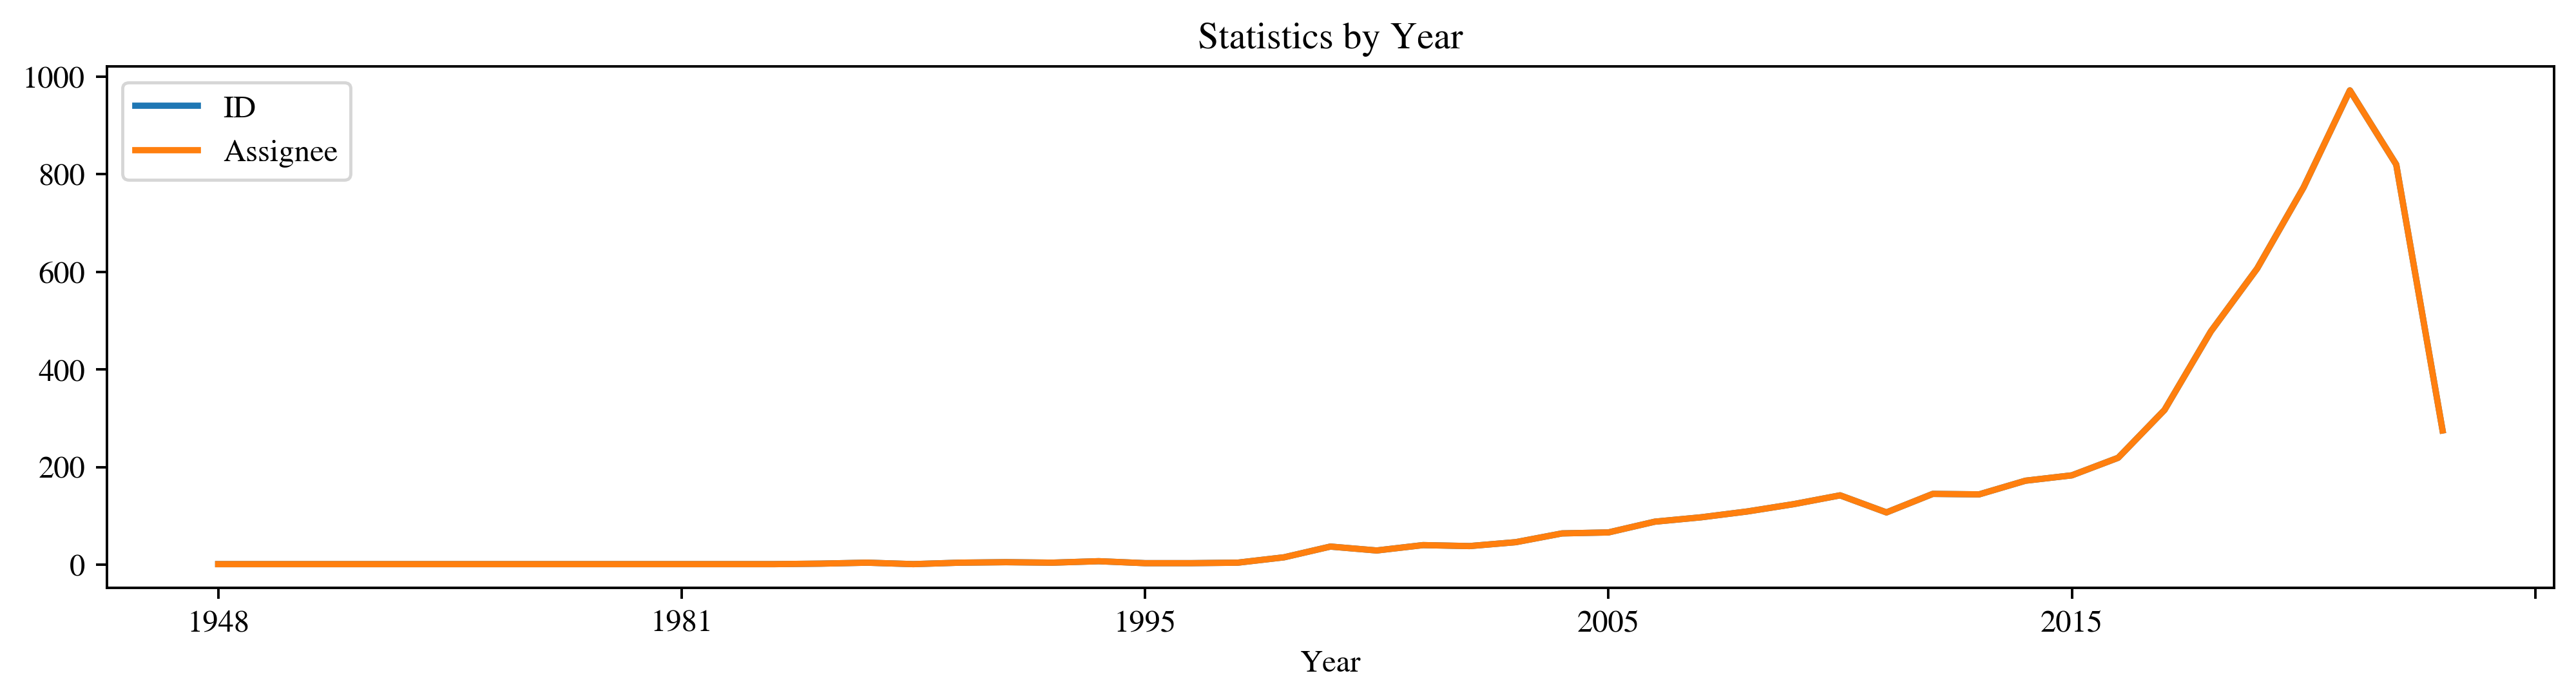

In [226]:
# Index the data
indexed_dfYearly = wdYear.set_index(['Year'])

# Plot Yearly graph to determine any high level anomalies
indexed_dfYearly = wdYear.set_index(['Year']).plot(figsize=(14,3)).set_title('Statistics by Year')

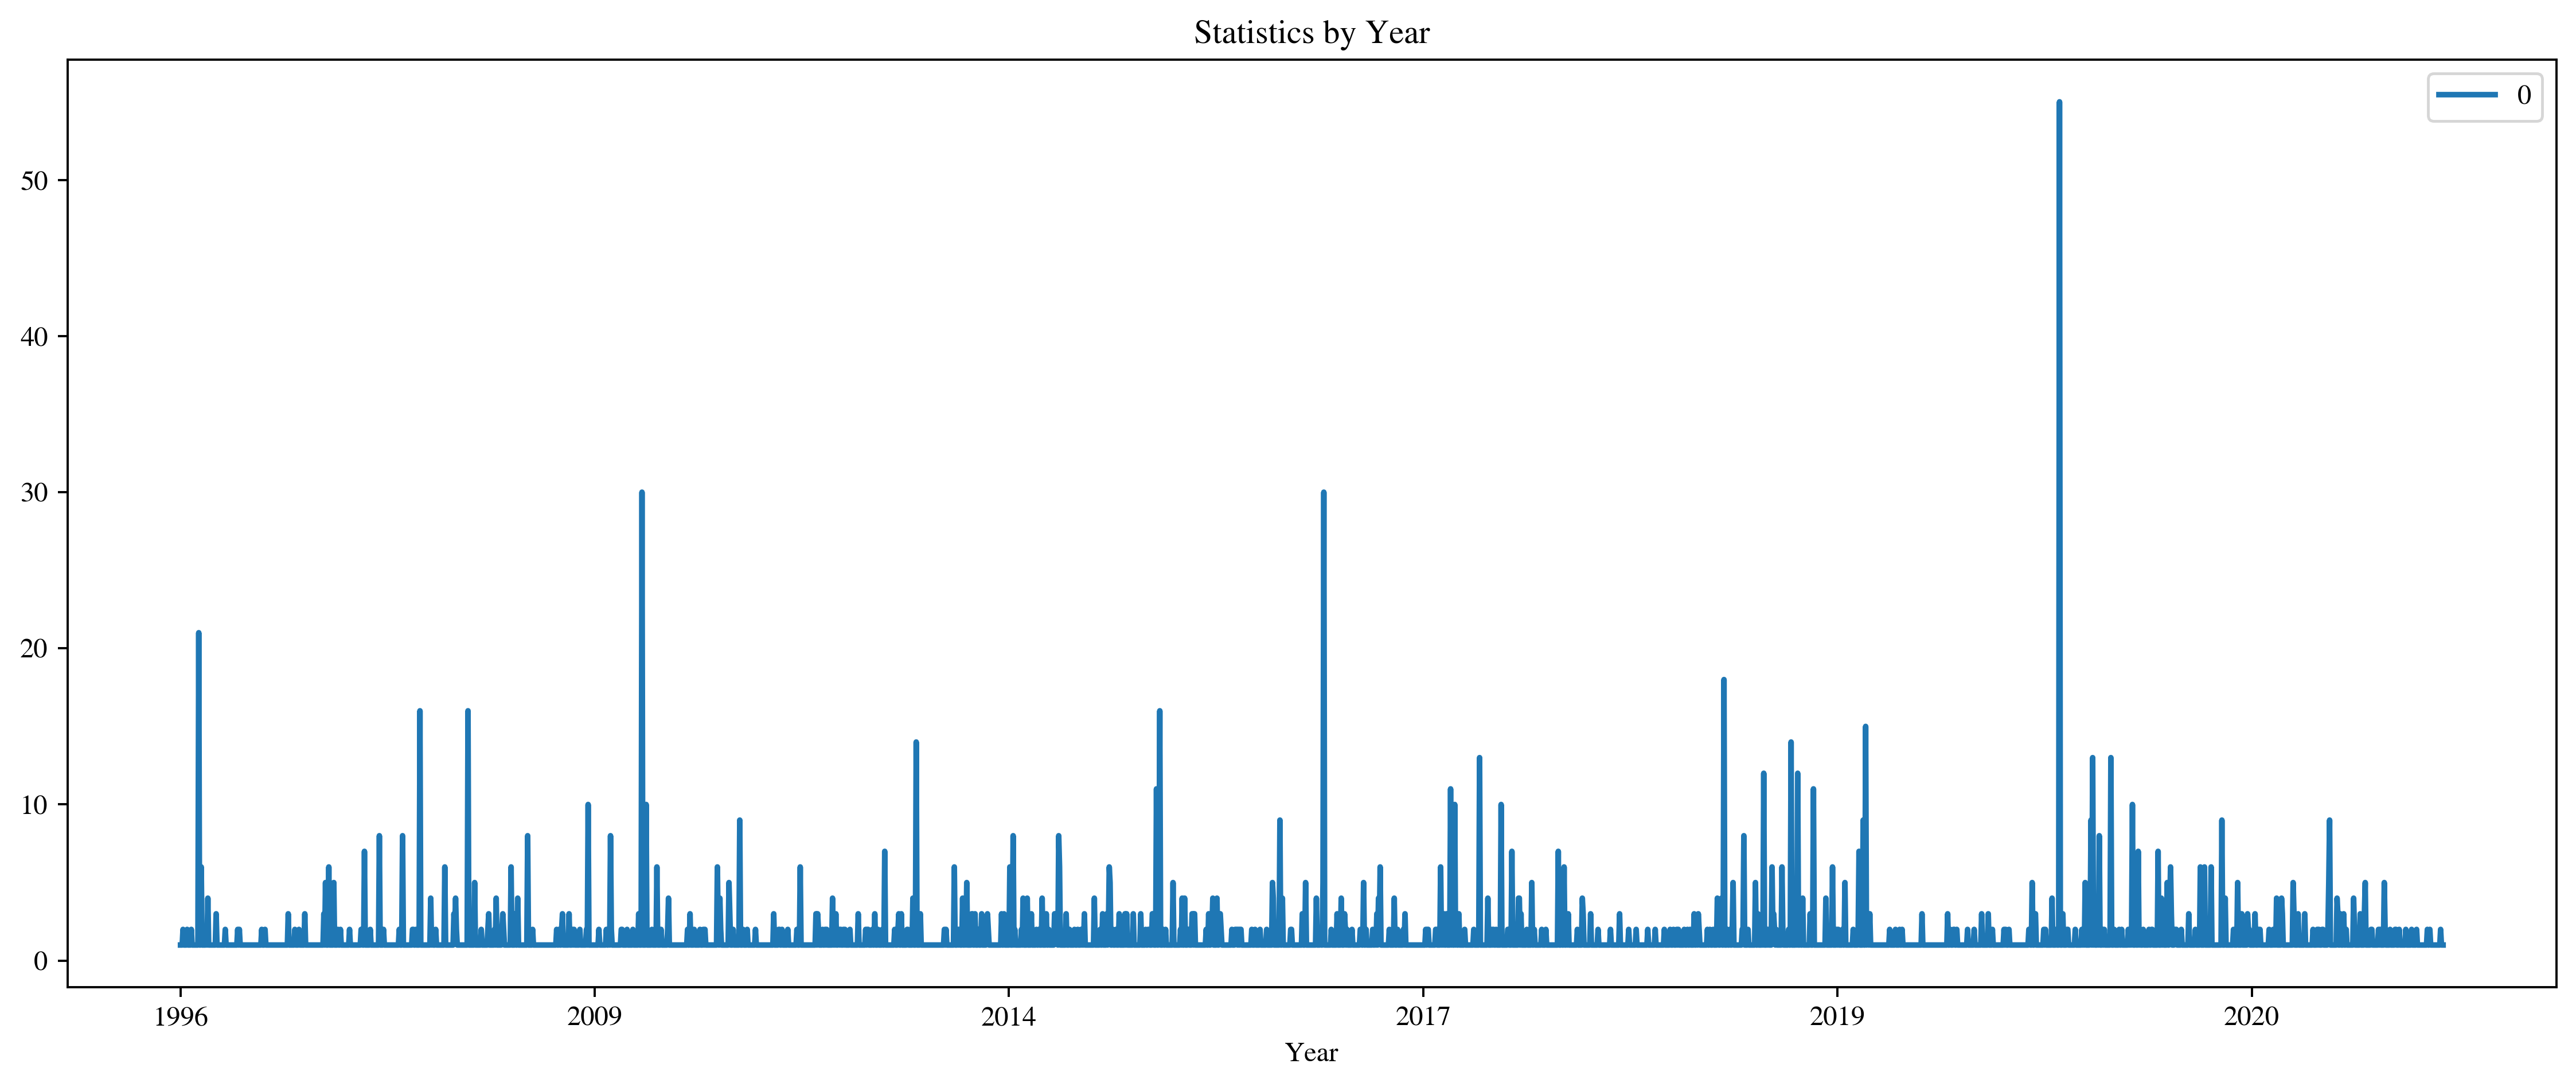

In [227]:
dfx = wd.groupby(['Year', 'Assignee']).size()

# Index the data
indexed_dfYearly = dfx.reset_index().set_index('Year')

# Plot Yearly graph to determine any high level anomalies
indexed_dfYearly_plot = dfx.reset_index().set_index(['Year']).plot(figsize=(16,6)).set_title('Statistics by Year')

## Period Leaders [1996-2020] <a class="anchor" id="period-leaders"></a>

In [298]:
# Establish statistics based on period
wd['Name'] = wd['Assignee']
dfE = select_period(wd, 1996, 2000, 'E').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfF = select_period(wd, 2001, 2005, 'F').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfG = select_period(wd, 2006, 2010, 'G').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfH = select_period(wd, 2011, 2015, 'H').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfI = select_period(wd, 2016, 2020, 'I').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)

# Define column headers as tuples so the table lays out more effectively.
columns = pd.MultiIndex.from_tuples([
            ('1996-2000', 'Assignee'), ('1996-2000', 'Count'),
            ('2001-2005', 'Assignee'), ('2001-2005', 'Count'),
            ('2006-2010', 'Assignee'), ('2006-2010', 'Count'),
            ('2011-2015', 'Assignee'), ('2011-2015', 'Count'),
            ('2016-2020', 'Assignee'), ('2016-2020', 'Count'),
            ],
            names=['Assignee', 'Count']
            )

# Establish frame for combining statistics
combine = pd.DataFrame(index=range(7), columns=columns)

# Loop and combine top list
for i in range(7):
       combine = fill_stat2(combine, '1996-2000', dfE, i)
       combine = fill_stat2(combine, '2001-2005', dfF, i)
       combine = fill_stat2(combine, '2006-2010', dfG, i)
       combine = fill_stat2(combine, '2011-2015', dfH, i)
       combine = fill_stat2(combine, '2016-2020', dfI, i)

combine

Assignee                        1996-2000        \
Count                            Assignee Count   
0                   Diebold, Incorporated    29   
1         International Business Machines     8   
2                                Li Yubin     3   
3                 N*able Technologies Inc     2   
4                        American Express     2   
5                           Certicom Corp     1   
6                       Critical Path Inc     1   

Assignee                                          2001-2005        \
Count                                              Assignee Count   
0                                     Microsoft Corporation    15   
1                                     Diebold, Incorporated    14   
2                                                    Huawei     8   
3         Electronics and Telecommunications Research In...     6   
4                                    Sap Aktiengesellschaft     4   
5                                            Ntt Docomo Inc     3   
6                                     Toshiba Res Europ Ltd     3   

Assignee                                          2006-2010        \
Count                                              Assignee Count   
0                                     Microsoft Corporation    54   
1               Aspire Digital Technology (shenzhen) CO Ltd    30   
2                           Go Daddy Operating Company, LLC    15   
3                                      Bundesdruckerei Gmbh    15   
4                                            Alcatel Lucent    13   
5         Electronics and Telecommunications Research In...    12   
6                 Beijing Feitian Chengxin Technology COLTD    12   

Assignee                             2011-2015        \
Count                                 Assignee Count   
0                         Bundesdruckerei Gmbh    23   
1                        Microsoft Corporation    17   
2             Verizon Patent And Licensing Inc    15   
3                      Cisco Technologies, Inc    15   
4                                   Tyfone Inc    15   
5         Zhuhai Untech Power Technology COLTD    13   
6              Go Daddy Operating Company, LLC    11   

Assignee                              2016-2020        
Count                                  Assignee Count  
0                                Alibaba/Alipay    82  
1              Oracle International Corporation    52  
2                                Forcepoint LLC    38  
3               International Business Machines    30  
4         Mastercard International Incorporated    29  
5                          Bundesdruckerei Gmbh    28  
6                   Bank Of America Corporation    25

In [230]:
# Establish statistics based on period
wd['Name'] = wd['Assignee']
dfE = select_period(wd, 2016, 2016, 'E').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfF = select_period(wd, 2017, 2017, 'F').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfG = select_period(wd, 2018, 2018, 'G').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfH = select_period(wd, 2019, 2019, 'H').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfI = select_period(wd, 2020, 2020, 'I').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)

# Define column headers as tuples so the table lays out more effectively.
columns = pd.MultiIndex.from_tuples([
            ('2016', 'Assignee'), ('2016', 'Count'),
            ('2017', 'Assignee'), ('2017', 'Count'),
            ('2018', 'Assignee'), ('2018', 'Count'),
            ('2019', 'Assignee'), ('2019', 'Count'),
            ('2020', 'Assignee'), ('2020', 'Count'),
            ],
            names=['Assignee', 'Count']
            )

# Establish frame for combining all key player statistics
combine = pd.DataFrame(index=range(10), columns=columns)

# Loop and combine top ten list
for i in range(10):
       combine = fill_stat2(combine, '2016', dfE, i)
       combine = fill_stat2(combine, '2017', dfF, i)
       combine = fill_stat2(combine, '2018', dfG, i)
       combine = fill_stat2(combine, '2019', dfH, i)
       combine = fill_stat2(combine, '2020', dfI, i)
combine


Assignee                              2016        \
Count                             Assignee Count   
0                      Cognitive Scale Inc    16   
1                     Bundesdruckerei Gmbh    11   
2          International Business Machines     5   
3                    Microsoft Corporation     4   
4                            Mystic Valley     4   
5         Verizon Patent And Licensing Inc     4   
6                            Wang Yancheng     4   
7                  Cisco Technologies, Inc     4   
8              Sebastien Jean Serge Dupont     3   
9                                 Sal Khan     3   

Assignee                                   2017        \
Count                                  Assignee Count   
0              Oracle International Corporation    30   
1                          Bundesdruckerei Gmbh     9   
2                                  北京梆梆安全科技有限公司     6   
3                   Bank Of America Corporation     5   
4                                     Zhengzhou     5   
5                    Northern Trust Corporation     5   
6               International Business Machines     5   
7                                 T-central Inc     4   
8         Mastercard International Incorporated     4   
9                                  北京中广掌视科技有限公司     4   

Assignee                                            2018        \
Count                                           Assignee Count   
0                                         Forcepoint LLC    13   
1                            Bank Of America Corporation    11   
2                                    Black Gold Coin Inc    10   
3                        International Business Machines    10   
4         State Farm Mutual Automobile Insurance Company     7   
5                                            Launch Tech     7   
6                                         Alibaba/alipay     6   
7                                           Tencent Tech     6   
8                       Oracle International Corporation     5   
9                            Honeywell International Inc     4   

Assignee                                    2019        \
Count                                   Assignee Count   
0                                 Alibaba/alipay    18   
1                                    Workday Inc    15   
2                                    Launch Tech    14   
3          Mastercard International Incorporated    12   
4                                 Forcepoint LLC    12   
5               Oracle International Corporation    11   
6                            Wells Fargo Bank NA     9   
7                                   China Unicom     8   
8         Visa International Service Association     7   
9                    Honeywell International Inc     6   

Assignee                                             2020        
Count                                            Assignee Count  
0                                          Alibaba/alipay    55  
1                                          Forcepoint LLC    13  
2                                 Cisco Technologies, Inc    13  
3         Industrial And Commercial Bank Of China Limited    10  
4                                     Wells Fargo Bank NA     9  
5                                          山东爱城市网信息技术有限公司     9  
6                                            China Unicom     9  
7                                        Dell Products LP     8  
8                   Mastercard International Incorporated     7  
9                                               JOURNEYAI     7

## Company Patent Metrics <a class="anchor" id="company-patent-metrics"></a>

In [231]:
display_entity(wdfull, "Diebold", ["bank", "machine", "privacy", "trust"], [])

Dataset Patent Count: 6157

Company: Diebold
  Patents (Total): 49
  Patents (Period [1996-2020]): 49
  Patents (After [2021-2023]): 0
  Patents with word (bank): 37
  Patents with word (machine): 39
  Patents with word (privacy): 0
  Patents with word (trust): 0

1997-11-25 00:00:00: Automated banking machine apparatus and system .. (US-7567924-B1)
2012-12-10 00:00:00: Automated banking machine that operates responsive to data bearing records .. (US-8474705-B2)


In [232]:
display_entity(wdfull, "Microsoft", ["transaction", "game", "privacy", "trust"], [("Kim Cameron", 1999, 2011, [])])

Dataset Patent Count: 6157

Company: Microsoft
  Patents (Total): 117
  Patents (Period [1996-2020]): 101
  Patents (After [2021-2023]): 16
  Patents with word (transaction): 8
  Patents with word (game): 8
  Patents with word (privacy): 3
  Patents with word (trust): 4
  Patents in range (Kim Cameron): 78

2002-03-22 00:00:00: Systems and methods for distributing trusted certification authorities .. (US-7240194-B2)
2022-11-24 00:00:00: Application identity account compromise detection .. (WO-2023121825-A1)


In [233]:
display_entity(wdfull, "Bundesdruckerei", ["token", "attribute"], [("National ID", 2015, 2016, [])])

Dataset Patent Count: 6157

Company: Bundesdruckerei
  Patents (Total): 67
  Patents (Period [1996-2020]): 66
  Patents (After [2021-2023]): 1
  Patents with word (token): 34
  Patents with word (attribute): 20
  Patents in range (National ID): 19

2008-09-22 00:00:00: Method for storing data for managing digital identity of user, involves wri.. (DE-102008042262-A1)
2021-02-19 00:00:00: User authentication using two independent security elements .. (DE-102021103997-A1)


In [234]:
display_entity(wdfull, "Oracle", ["token", "attribute"], [("2016-2020", 2016, 2020, ""),("2017", 2017, 2017, ["multi-ten", "cloud", "security"])])

Dataset Patent Count: 6157

Company: Oracle
  Patents (Total): 61
  Patents (Period [1996-2020]): 57
  Patents (After [2021-2023]): 4
  Patents with word (token): 1
  Patents with word (attribute): 2
  Patents in range (2016-2020): 52
  Patents in range (2017): 30
  Patents in range (2017) with word (multi-ten): 18
  Patents in range (2017) with word (cloud): 22
  Patents in range (2017) with word (security): 14

2004-06-25 00:00:00: Authentication system and method for operating the same .. (US-8447984-B1)
2022-03-03 00:00:00: Dynamic membership assignment to users using dynamic rules .. (US-2022191213-A1)


In [235]:
display_entity(wdfull, "Cognitive", ["blockchain", "graph","chain","payment"], [])

Dataset Patent Count: 6157

Company: Cognitive
  Patents (Total): 17
  Patents (Period [1996-2020]): 17
  Patents (After [2021-2023]): 0
  Patents with word (blockchain): 16
  Patents with word (graph): 2
  Patents with word (chain): 16
  Patents with word (payment): 0

2016-11-09 00:00:00: Method for cognitive information processing using a cognitive blockchain ar.. (US-10719771-B2)
2020-01-02 00:00:00: Facilitation of Transparency of Claim-Settlement Processing by a Third-Part.. (US-2021209688-A1)


In [236]:
display_entity(wdfull, "Bank Of America", ["blockchain"], [])

Dataset Patent Count: 6157

Company: Bank Of America
  Patents (Total): 38
  Patents (Period [1996-2020]): 25
  Patents (After [2021-2023]): 13
  Patents with word (blockchain): 26

2016-02-22 00:00:00: System to enable contactless access to a transaction terminal using a proce.. (US-10496989-B2)
2022-02-23 00:00:00: Intelligently managing invoice processing using blockchain and mixed realit.. (US-2023267518-A1)


In [297]:
display_entity(wdfull, "International Business Machines", ["access","blockchain", "privacy", "auth"], [])

Dataset Patent Count: 6157

Company: International Business Machines
  Patents (Total): 63
  Patents (Period [1996-2020]): 54
  Patents (After [2021-2023]): 9
  Patents with word (access): 7
  Patents with word (blockchain): 16
  Patents with word (privacy): 3
  Patents with word (auth): 6

1998-07-30 00:00:00: A portable information and transaction processing device system and method .. (HU-0004470-A2)
2022-12-12 00:00:00: Recertification of access control information based on context information .. (WO-2023111827-A1)


In [240]:
display_entity(wdfull, "Alibaba", ["chain","auth","invoic","data management","communication"], [("2018-2023", 2018, 2023, "")])

Dataset Patent Count: 6157

Company: Alibaba
  Patents (Total): 150
  Patents (Period [1996-2020]): 85
  Patents (After [2021-2023]): 65
  Patents with word (chain): 54
  Patents with word (auth): 17
  Patents with word (invoic): 3
  Patents with word (data management): 3
  Patents with word (communication): 1
  Patents in range (2018-2023): 144

2011-11-04 00:00:00: Information interactive method among non-login users and device .. (CN-103095663-A)
2023-05-04 00:00:00: Identity authorization method and device based on blockchain .. (CN-116647371-A)


In [238]:
display_entity(wdfull, "Mastercard", ["payment","authen"], [])

Dataset Patent Count: 6157

Company: Mastercard
  Patents (Total): 62
  Patents (Period [1996-2020]): 33
  Patents (After [2021-2023]): 29
  Patents with word (payment): 9
  Patents with word (authen): 8

2005-08-17 00:00:00: Compliance assessment and security testing of smart cards .. (CA-2577482-A1)
2023-04-05 00:00:00: Systems and methods for managing user identities in networks .. (US-2023246840-A1)


## Company Patents By Year<a class="anchor" id="company-patents-by-year"></a>

In [38]:
indexed_dfYearly2 = indexed_dfYearly.reset_index().groupby(['Year','Assignee'])
df1 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Microsoft Corporation')]
df2 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'International Business Machines Corporation')]
df3 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Oracle International Corporation')]
df4 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Diebold, Incorporated')]
df5 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Bundesdruckerei Gmbh')]
df6 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Bank Of America Corporation')]
df7 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Cisco Technology, Inc.')]
df8 = indexed_dfYearly[(indexed_dfYearly.Assignee == '阿里巴巴集团控股有限公司')]
df9 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Mastercard International Incorporated')]
df10 = indexed_dfYearly[(indexed_dfYearly.Assignee == '支付宝(杭州)信息技术有限公司')]

frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

result = pd.concat(frames)
result = result.rename(columns={'0': 'Count'})
result = pd.pivot_table(result, index=['Year'], columns = 'Assignee')
result = result.fillna(0)
result.columns = result.columns.droplevel()
display(result.head(50))

Assignee,Bank Of America Corporation,Bundesdruckerei Gmbh,"Cisco Technology, Inc.","Diebold, Incorporated",International Business Machines Corporation,Mastercard International Incorporated,Microsoft Corporation,Oracle International Corporation
Year,,,,,,,,
1997,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,0.0,21.0,6.0,0.0,0.0,0.0
2000,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0
2001,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2002,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2003,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0
2004,0.0,0.0,0.0,3.0,1.0,0.0,5.0,0.0
2005,0.0,0.0,0.0,7.0,0.0,0.0,8.0,1.0


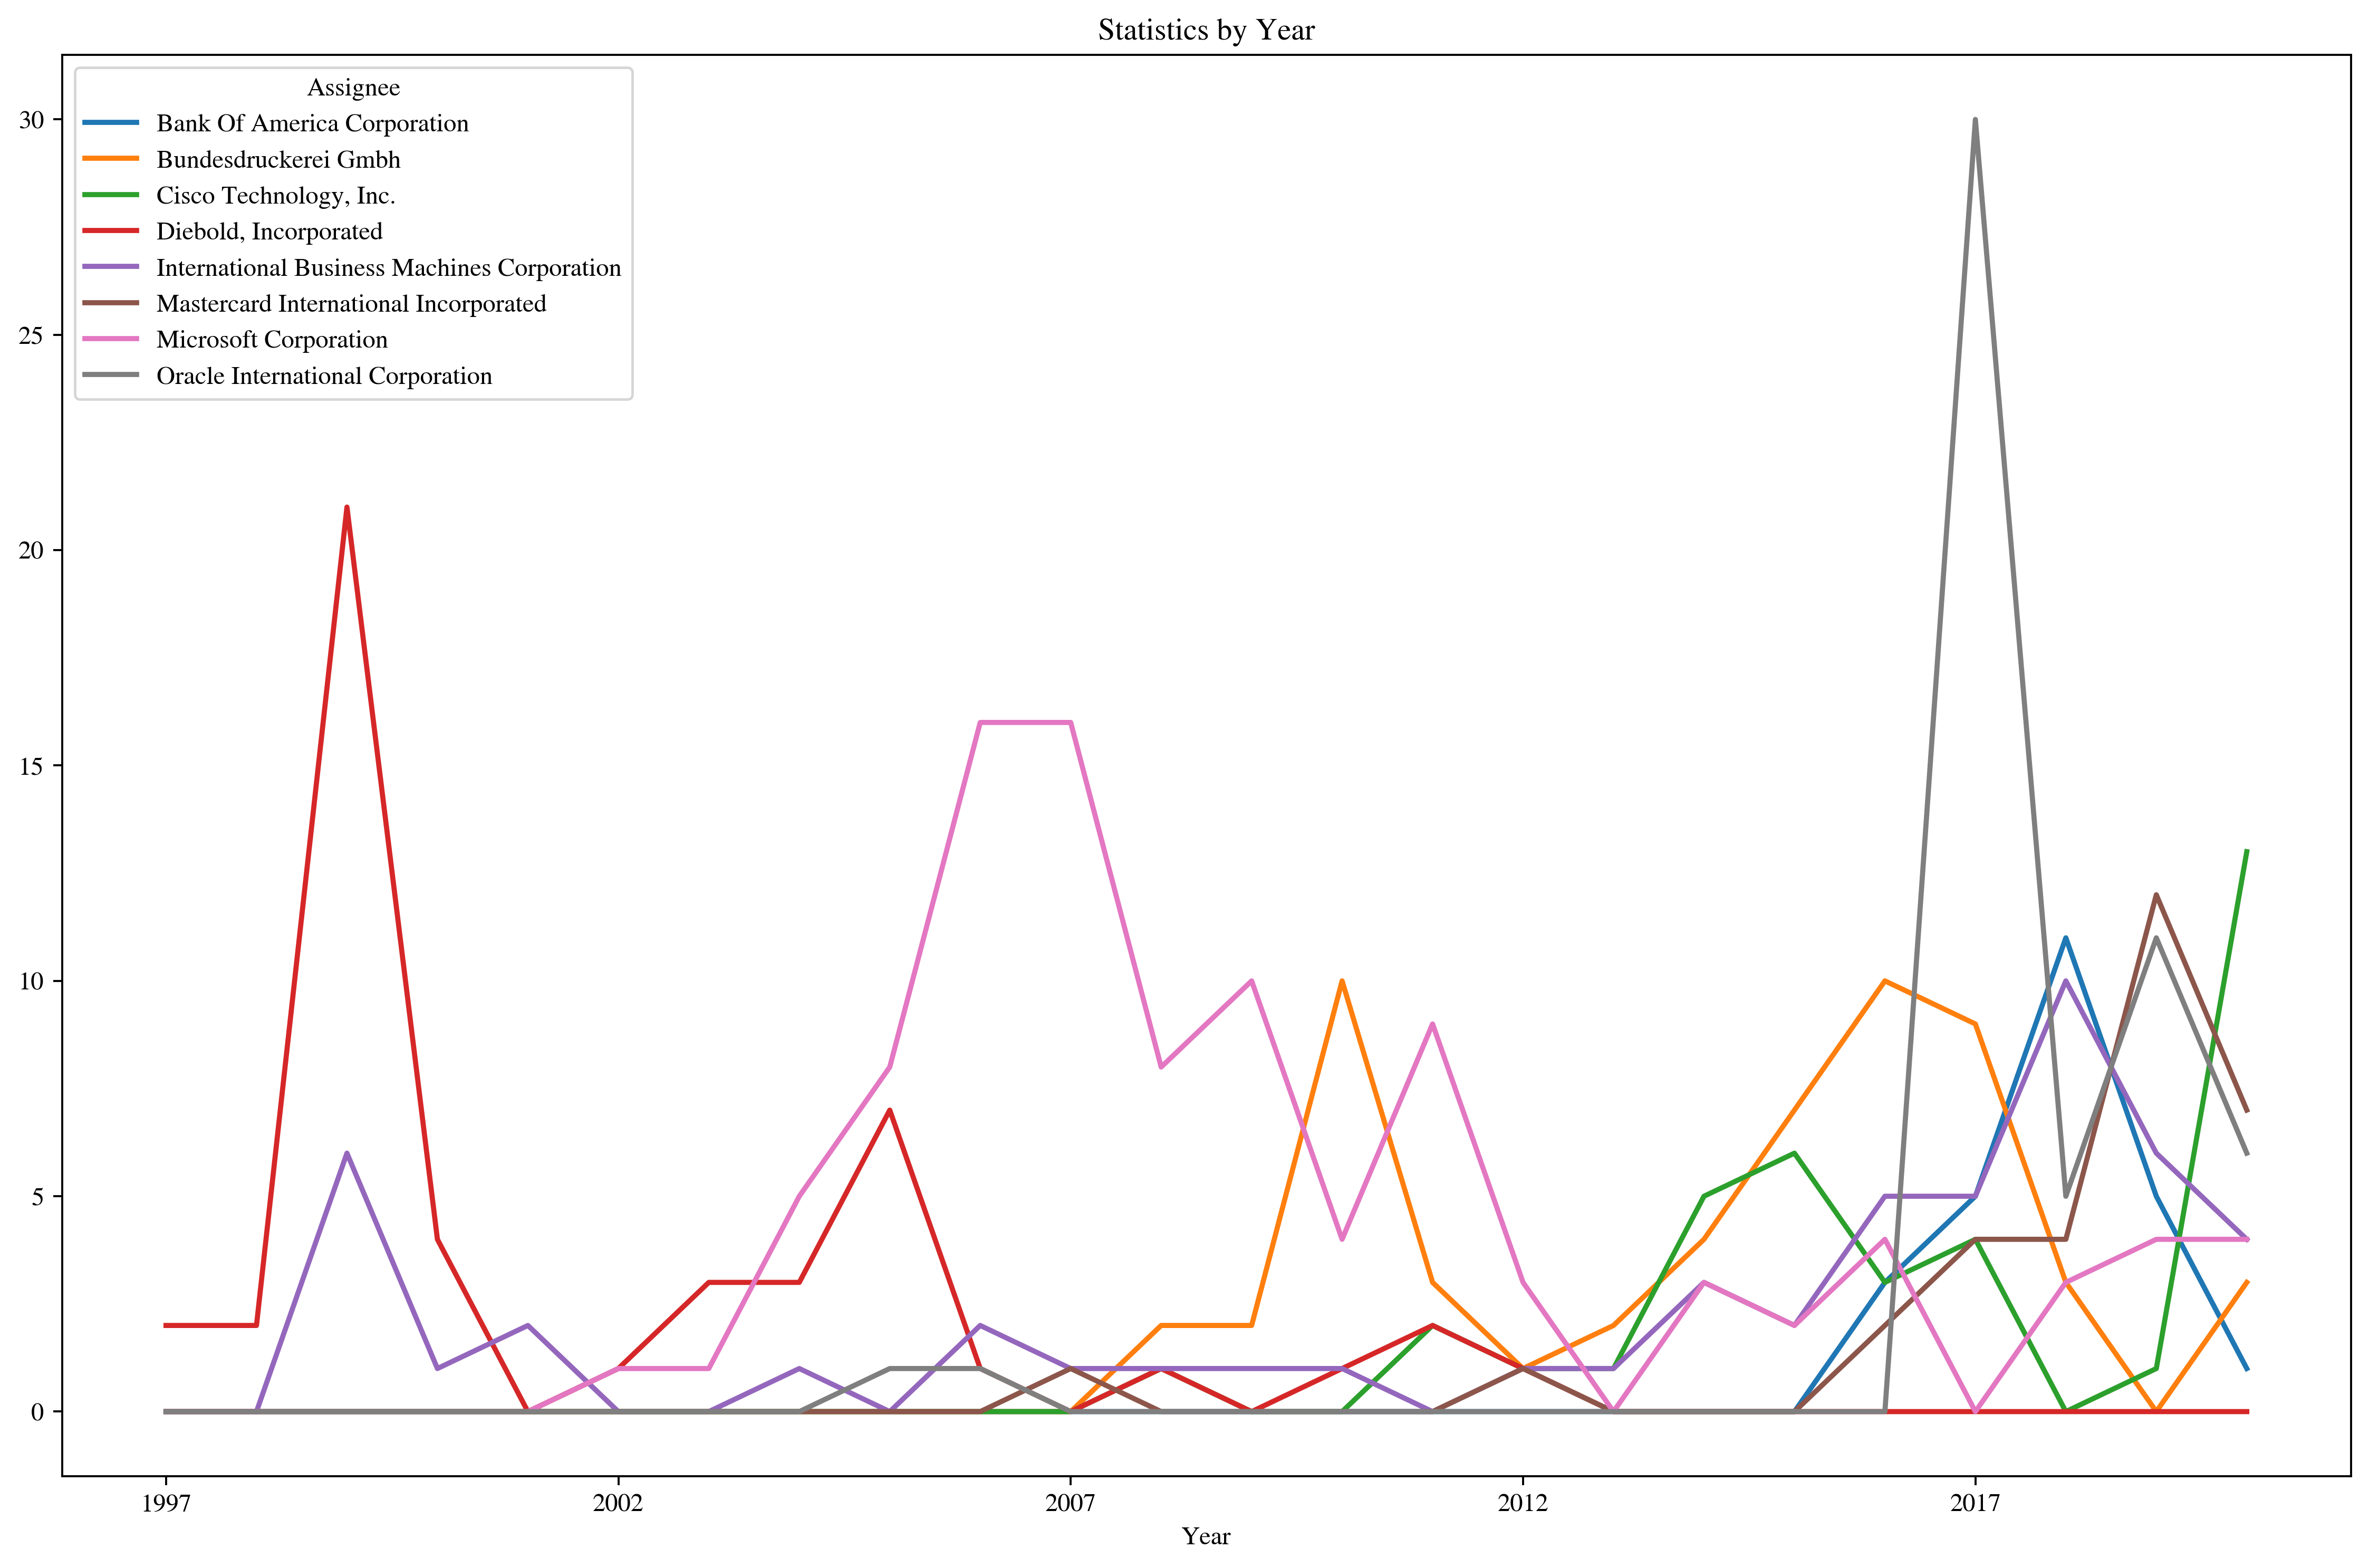

In [39]:
import warnings
warnings.filterwarnings("ignore")

result_plot = result.plot(figsize=(16,10)).set_title('Statistics by Year')

## Company Patent Links<a class="anchor" id="company-patent-links"></a>

In [40]:
print_all_patents(wdfull, "Microsoft")

Dataset Patent Count: 6157

Company: Microsoft
Patents for Period [1996-2020]


Patents for After [2021-2023]


## Patent Downloading<a class="anchor" id="patent-downloading"></a>

In [102]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

In [103]:
"""Scrape metadata from target URL."""
import requests
from bs4 import BeautifulSoup
import pprint
import urllib

def get_download_url(url):
    """Scrape target URL for metadata."""
    headers = {
        'Access-Control-Allow-Origin': '*',
        'Access-Control-Allow-Methods': 'GET',
        'Access-Control-Allow-Headers': 'Content-Type',
        'Access-Control-Max-Age': '3600',
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
    
    r = requests.get(url, headers=headers)
    html = BeautifulSoup(r.content, 'html.parser')
    print(html)
    return get_pdf(html)
    
def download_file(url, filename):
    urllib.urlretrieve ("http://www.example.com/songs/mp3.mp3", "mp3.mp3")

def scrape_page_metadata(url):
    """Scrape target URL for metadata."""
    headers = {
        'Access-Control-Allow-Origin': '*',
        'Access-Control-Allow-Methods': 'GET',
        'Access-Control-Allow-Headers': 'Content-Type',
        'Access-Control-Max-Age': '3600',
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
    
    r = requests.get(url, headers=headers)
    html = BeautifulSoup(r.content, 'html.parser')
    metadata = {
        'title': get_title(html),
        'description': get_description(html),
        'pdf': get_pdf(html),
        'image': get_image(html),
        'favicon': get_favicon(html, url),
        'sitename': get_site_name(html, url),
        'color': get_theme_color(html),
        'url': url
        }

    return metadata


def get_title(html):
    """Scrape page title."""
    title = None
    if html.title.string:
        title = html.title.string
    elif html.find("meta", property="og:title"):
        title = html.find("meta", property="og:title").get('content')
    elif html.find("meta", property="twitter:title"):
        title = html.find("meta", property="twitter:title").get('content')
    elif html.find("h1"):
        title = html.find("h1").string
    return title

def get_pdf(html):
    return html.find("meta",  {"name":"citation_pdf_url"}).get('content')

def get_description(html):
    """Scrape page description."""
    description = None
    if html.find("meta", property="description"):
        description = html.find("meta", property="description").get('content')
    elif html.find("meta", property="og:description"):
        description = html.find("meta", property="og:description").get('content')
    elif html.find("meta", property="twitter:description"):
        description = html.find("meta", property="twitter:description").get('content')
    elif html.find("p"):
        description = html.find("p").contents
    return description


def get_image(html):
    """Scrape share image."""
    image = None
    if html.find("meta", property="image"):
        image = html.find("meta", property="image").get('content')
    elif html.find("meta", property="og:image"):
        image = html.find("meta", property="og:image").get('content')
    elif html.find("meta", property="twitter:image"):
        image = html.find("meta", property="twitter:image").get('content')
    elif html.find("img", src=True):
        image = html.find_all("img")[0].get('src')
    return image


def get_site_name(html, url):
    """Scrape site name."""
    if html.find("meta", property="og:site_name"):
        site_name = html.find("meta", property="og:site_name").get('content')
    elif html.find("meta", property='twitter:title'):
        site_name = html.find("meta", property="twitter:title").get('content')
    else:
        site_name = url.split('//')[1]
        return site_name.split('/')[0].rsplit('.')[1].capitalize()
    return sitename


def get_favicon(html, url):
    """Scrape favicon."""
    if html.find("link", attrs={"rel": "icon"}):
        favicon = html.find("link", attrs={"rel": "icon"}).get('href')
    elif html.find("link", attrs={"rel": "shortcut icon"}):
        favicon = html.find("link", attrs={"rel": "shortcut icon"}).get('href')
    else:
        favicon = f'{url.rstrip("/")}/favicon.ico'
    return favicon


def get_theme_color(html):
    """Scrape brand color."""
    if html.find("meta", property="theme-color"):
        color = html.find("meta", property="theme-color").get('content')
        return color
    return None

In [104]:
import requests
import json
import urllib.request
from pathlib import Path
import pdfplumber
from sklearn.feature_extraction.text import CountVectorizer
import re
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
    
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

from bs4 import BeautifulSoup
pp = pprint.PrettyPrinter(indent=4)
for index, row in microsoft.iterrows():
    url = row['Result']
    print(url)
    #print(get_download_url(url))
    data = scrape_page_metadata(url)
    
    pdfURL = data["pdf"]
    print(pdfURL)
    
    path = "./PDF/" + row['Assignee']
    Path(path).mkdir(parents=True, exist_ok=True)
    
    path = "./PDF/" + row['Assignee'] + '/' + row['ID'] + ".pdf"
    print(path)
    urllib.request.urlretrieve(pdfURL, path)
    
    pages = list()
    fulltext = "";
    count = 0;
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            text = pre_process(text)
            
            pages.append(text)
            count = count +1;
            if count > 15:
                fulltext = fulltext + text;

            #load a set of stop words
        stopwords=get_stop_words("./Files/stopwords.txt")

        #get the text column 
        #docs=df_idf['text'].tolist()

        #create a vocabulary of words, 
        #ignore words that appear in 85% of documents, 
        #eliminate stop words
        cv = CountVectorizer(max_df = 1, stop_words = stopwords, max_features = 10000)
        word_count_vector = cv.fit_transform(pages)  
            
        feature_names=cv.get_feature_names()
        #print(feature_names)
        
        from multi_rake import Rake

        rake = Rake()
        rake.max_words = 100000

        keywords = rake.apply(fulltext)
        
        print(fulltext)

        print(keywords[:10])

    break

https://patents.google.com/patent/US8104074B2/en
https://patentimages.storage.googleapis.com/57/c5/c0/8164ac58ecb706/US8104074.pdf
./PDF/Microsoft Corporation/US-8104074-B2.pdf
us b negotiation the ability for the various parties of the digi tive embodiments one or more other specifications can be tal identity system to make agreements regarding mutu used to facilitate communications between the various sub ally acceptable technologies claims and other require systems in system ments in example embodiments principal relying party encapsulation the ability to exchange requirements and and identity provider can each utilize one or more a claims in a technology neutral way between parties computer systems each computer system includes one or subsystems and more of volatile and non volatile computer readable media transformation the ability to translate claims between computer readable media includes storage media as well as technologies and semantically removable and non removable media i

Note: you may need to restart the kernel to use updated packages.


In [2]:
aa2=2
print(aa2)

2
